# An end-to-end project in Machine Learning

## Using machine learning to predict bike rentals

### Based on the notebook by Mauricio A Álvarez

Our dataset comes from a popular machine learning repository that hosts open source datasets for educational and research purposes, the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). We are going to follow several of the steps in the ML project checklist and use several utilities and models in [scikit-learn](https://scikit-learn.org/stable/) for predicting bike rentals. The description of the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand#).

### Get the data

In [1]:
import urllib.request
urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv', './SeoulBikeData.csv')

('./SeoulBikeData.csv', <http.client.HTTPMessage at 0x1f569244f50>)

In [2]:
import pandas as pd
bike_sharing_data = pd.read_csv('SeoulBikeData.csv', encoding= 'unicode_escape')

We can get a description of the data

In [3]:
bike_sharing_data.describe()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


We can see some of the rows in the dataset

In [4]:
bike_sharing_data.sample(5)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
7246,28/09/2018,0,22,17.1,70,1.0,2000,11.5,0.00,0.0,0.0,Autumn,No Holiday,No
6443,26/08/2018,791,11,28.0,46,1.7,1990,15.2,2.73,0.0,0.0,Summer,No Holiday,Yes
4496,06/06/2018,799,8,21.2,59,1.2,794,12.8,1.13,0.0,0.0,Summer,Holiday,Yes
5808,31/07/2018,901,0,31.0,54,0.8,2000,20.5,0.00,0.0,0.0,Summer,No Holiday,Yes
693,29/12/2017,282,21,1.0,77,1.5,297,-2.5,0.00,0.0,0.0,Winter,No Holiday,Yes


The target variable that we're interested in (that we call $y$) corresponds to the Rented Bike Count variable of the second column. The feature vector (i.e. the independent variables), that we call $\mathbf{x}$ are made of the next twelve columns. So *hour* is $x_1$, *Temperature* is $x_2$...etc. The original dataset also has a date column that we are not going to use in this notebook.

In [5]:
bike_sharing_data = bike_sharing_data.drop('Date', axis=1)

We follow some of the steps in the ML checklist we used in the lecture, including data exploration, data preprocessing, and fine-tuning the ML model.

- Remember: test data that we later use for assessing the generalisation performance has to be set aside when we first get the data.

- Any data preprocessing that you do should mostly be done just on the training data. Separating the dataset into training and test before any preprocessing has happened, help us to recreate the real world scenario where we will deploy our system and for which the data will come without any preprocessing. Here though we'll first convert the integer columns to floats.

- We will use scikit-learn to separate the data into training and test sets.

Let us first look at how many instances we have in the dataset

In [6]:
bike_sharing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rented Bike Count          8760 non-null   int64  
 1   Hour                       8760 non-null   int64  
 2   Temperature(°C)            8760 non-null   float64
 3   Humidity(%)                8760 non-null   int64  
 4   Wind speed (m/s)           8760 non-null   float64
 5   Visibility (10m)           8760 non-null   int64  
 6   Dew point temperature(°C)  8760 non-null   float64
 7   Solar Radiation (MJ/m2)    8760 non-null   float64
 8   Rainfall(mm)               8760 non-null   float64
 9   Snowfall (cm)              8760 non-null   float64
 10  Seasons                    8760 non-null   object 
 11  Holiday                    8760 non-null   object 
 12  Functioning Day            8760 non-null   object 
dtypes: float64(6), int64(4), object(3)
memory usage:

Several algorithms that we will use assume the inputs to be type 'float' instead of 'int', so we transform those variables in the dataset from int64 to float64.

In [7]:
for col in ['Rented Bike Count', 'Hour', 'Humidity(%)', 'Visibility (10m)']:
    bike_sharing_data[col] = bike_sharing_data[col].astype('float64')

In [8]:
bike_sharing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rented Bike Count          8760 non-null   float64
 1   Hour                       8760 non-null   float64
 2   Temperature(°C)            8760 non-null   float64
 3   Humidity(%)                8760 non-null   float64
 4   Wind speed (m/s)           8760 non-null   float64
 5   Visibility (10m)           8760 non-null   float64
 6   Dew point temperature(°C)  8760 non-null   float64
 7   Solar Radiation (MJ/m2)    8760 non-null   float64
 8   Rainfall(mm)               8760 non-null   float64
 9   Snowfall (cm)              8760 non-null   float64
 10  Seasons                    8760 non-null   object 
 11  Holiday                    8760 non-null   object 
 12  Functioning Day            8760 non-null   object 
dtypes: float64(10), object(3)
memory usage: 889.8+ K

The dataset has a few thousand observations. We will use 85% of the data for training and 15% for testing. The `train_test_split` function in scikit-learn allows to easily get these partitions.

- By specifying a value for `random_state`, we are making sure that every time we run this instruction, the train and test set will have the exact same instances. `random_state` "controls the shuffling applied to the data before applying the split".

In [9]:
from sklearn.model_selection import train_test_split
bs_train_set, bs_test_set = train_test_split(bike_sharing_data, test_size=0.15, random_state=42)

- The train and test sets are chosen randomly from all the available data.

**Question 1**
- a) Discuss whether splitting the data randomly is a good choice: Will it over-inflate our accuracy estimate?
- b) Does it depend on which classifier we use?
- b) What does it mean for generalisation?
- c) What steps have we skipped from end-to-end ML?

Answer here.

### Important Detour!

The key issue when answering the above questions is to think about spurious correlations that might inflate your accuracy.

Let's consider a simple toy example dataset.

We want to predict if we will make a profit from the bike hire scheme. We have a column for if a given hour is profitable (i.e. enough bikes are in use to turn a profit). We also have a column for the number of wind gusts that hour (we think that this can help predict our profits!).

We have two observations for each day (0-9):

In [10]:
#windy  bike hires
import numpy as np
example = np.array([[0,154],[0,153], [0,132],[0,133], [1,74],[1,72], [0,53],[0,52], [0,121],[0,123], [1,11],[1,14], [1,2],[1,3],[1,142],[1,143],[0,45],[0,46],[1,89],[1,88]])
exampleday = np.array([0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9])
df = pd.DataFrame(np.c_[exampleday,example],columns=['day','profit','gusts'])
df

,day,profit,gusts
0,0,0,154
1,0,0,153
2,1,0,132
3,1,0,133
4,2,1,74
5,2,1,72
6,3,0,53
7,3,0,52
8,4,0,121
9,4,0,123


Question: Looking at the data, do you think that the number of gusts can *really* help predict the profit?

Let's find out. We split the data 70:30, randomly:

In [11]:
train_example, test_example = train_test_split(df, test_size=0.3, random_state=2)
print("TRAIN:")
print(train_example)
print("TEST:")
print(test_example)

TRAIN:
    day  profit  gusts
3     1       0    133
10    5       1     11
1     0       0    153
17    8       0     46
7     3       0     52
16    8       0     45
14    7       1    142
2     1       0    132
11    5       1     14
6     3       0     53
19    9       1     88
13    6       1      3
15    7       1    143
8     4       0    121
TEST:
    day  profit  gusts
12    6       1      2
4     2       1     74
18    9       1     89
0     0       0    154
9     4       0    123
5     2       1     72


We train a nearest neighbour classifier on the training data, and predict on the test data:

In [12]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(train_example[['gusts']],train_example['profit'])
print(neigh.predict(test_example[['gusts']])==test_example['profit'])

12    True
4     True
18    True
0     True
9     True
5     True
Name: profit, dtype: bool


Great it classified them all correctly.

The problem is that the number of gusts between two hours on the same day is strongly correlated. But an hour might be profitable for many other reasons. So it is likely that this success is due to having correlations in the number of gusts between hours on the same day.

To mitigate this, we need to be more careful about how we split our data. As an example, we can use `GroupShuffleSplit` to do this instead which allows us to pass a `groups` parameter telling it which rows are in the same group.

Here we are splitting the data using this method, note where we pass `groups = df['day']` to say how we want the data to be grouped when splitting.

In [13]:
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=2)
gss.get_n_splits()
train_idx, test_idx = next(gss.split(df, groups = df['day']))
train_group_example = df.iloc[train_idx]
test_group_example = df.iloc[test_idx]
print("TRAIN:")
print(train_group_example)
print("TEST:")
print(test_group_example)

TRAIN:
    day  profit  gusts
0     0       0    154
1     0       0    153
4     2       1     74
5     2       1     72
6     3       0     53
7     3       0     52
12    6       1      2
13    6       1      3
14    7       1    142
15    7       1    143
16    8       0     45
17    8       0     46
18    9       1     89
19    9       1     88
TEST:
    day  profit  gusts
2     1       0    132
3     1       0    133
8     4       0    121
9     4       0    123
10    5       1     11
11    5       1     14


Notice that different hours from the same day are in the same set.

Let's run the classifier again

In [14]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(train_group_example[['gusts']],train_group_example['profit'])
print(neigh.predict(test_group_example[['gusts']])==test_group_example['profit'])

2     False
3     False
8     False
9     False
10     True
11     True
Name: profit, dtype: bool


It's got 4 out of 6 of the predictions **wrong**! Maybe the number of wind gusts isn't useful for predicting profit afterall?

Take home message: The correlations in the data can lead to artificially inflated accuracies. Think carefully about how you split your data!


## Back to the Lab

Note: we are going to continue using the `train_test_split` approach - but notice that in this data we will definitely be wrongly inflating accuracy, as neighbouring hours of bike-hire activity are probably correlated in such a way that the analysis is wrong. Ideally we should use a similar approach to above to split the data correctly.

### Explore the data

There are different tools we can use to explore the dataset.

#### Histograms

Let us first look at histograms for each of the continuous attributes.

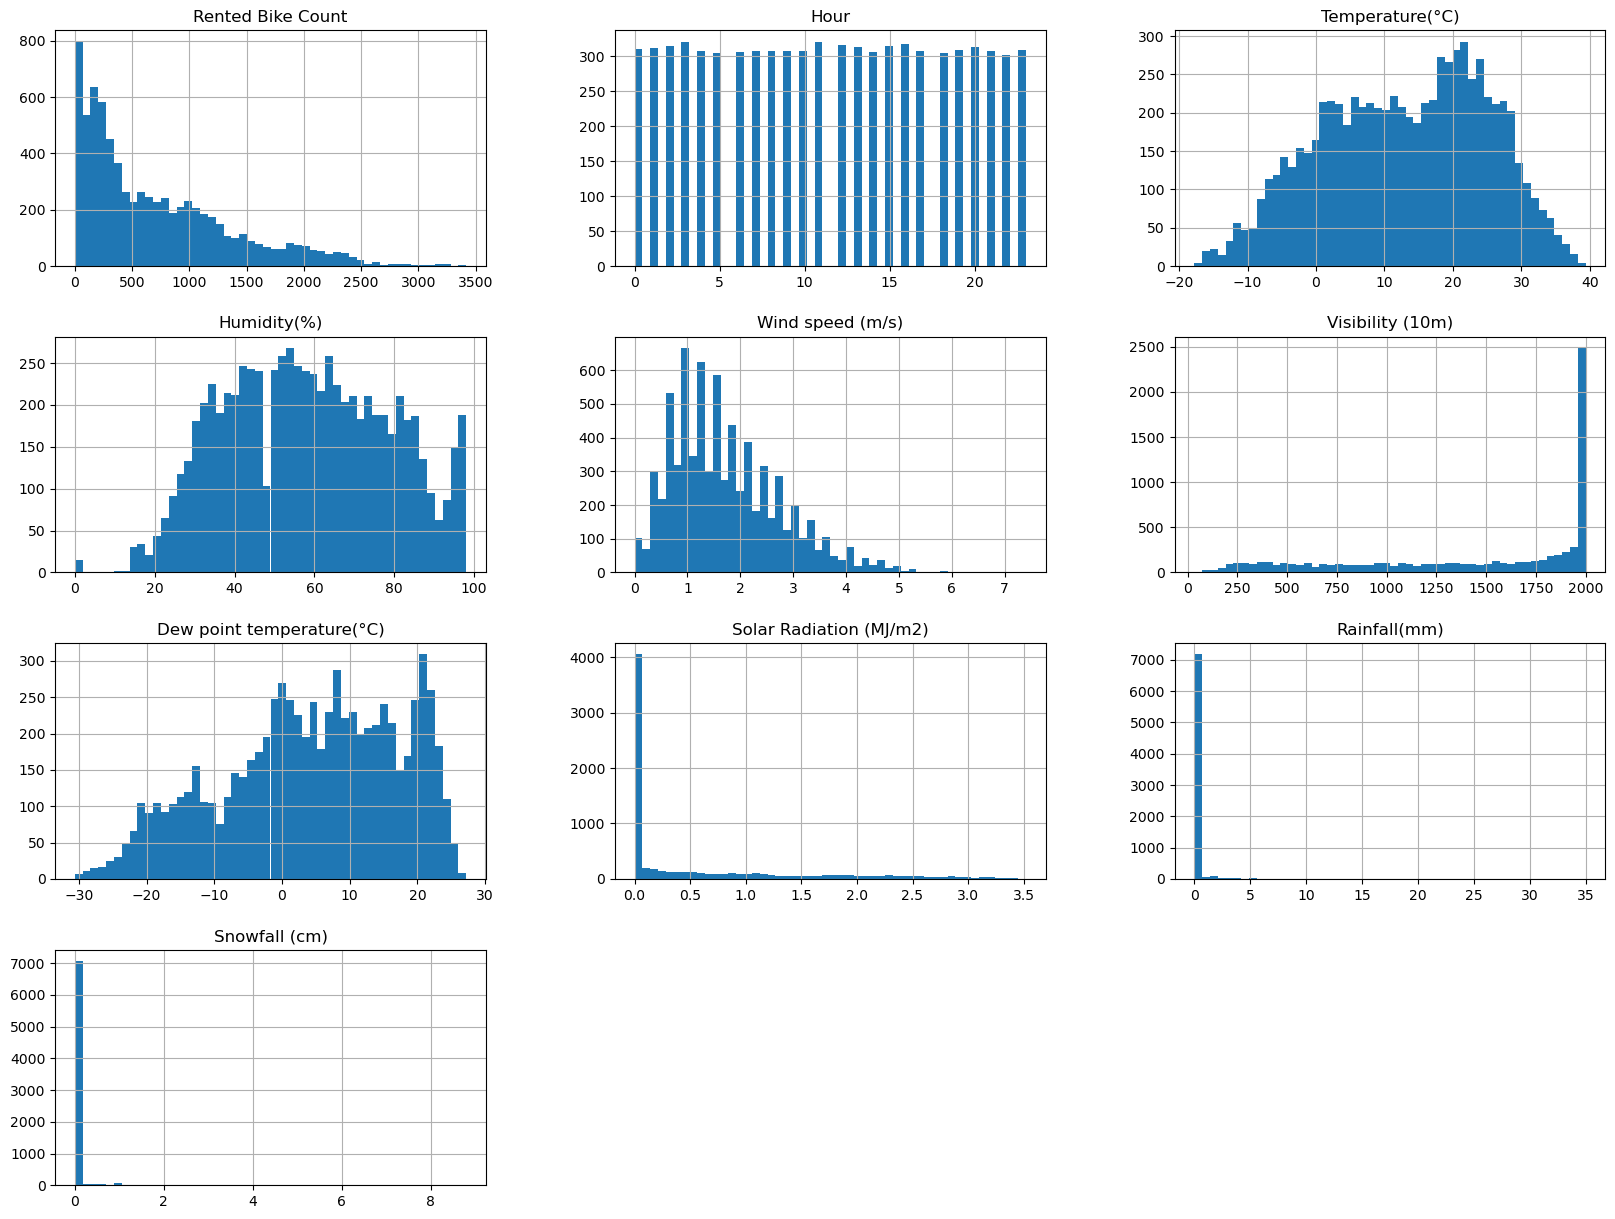

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
bs_train_set.hist(bins=50, figsize=(20,15))
plt.show()

Some observations from the histograms are:

1. The values for the variables Rainfall, Snowfall, Solar Radition and Visibility are concentrated at one of the ends of the plots. This is an indication that several instances might contain outliers. One can consider removing these outliers from the data or binning the data into a few discrete values.

2. Both the Rented Bike Count and the Wind Speed are [skewed to the right](https://en.wikipedia.org/wiki/Skewness), this is, the mean of the distribution is to the right of the median. Some ML algorithms find it harder to detect patterns for this type of distribution. One might consider transforming these features using $\log(x)$ or $\sqrt{x}$ so that they look more like a bell-shaped distribution.

#### Question 2

a. Compute the mean and the median for the variables Rented Bike Count and Wind Speed and verify that the mean is to the right of the median.

b. How would the histograms for Rented Bike Count and the Wind Speed look like if we transform the values using $\sqrt{x}$?

c. Would it be possible to use $\log{x}$ instead of $\sqrt{x}$? If not, what would you do to the variable to be able to use it?

705.8815471394037
507.0


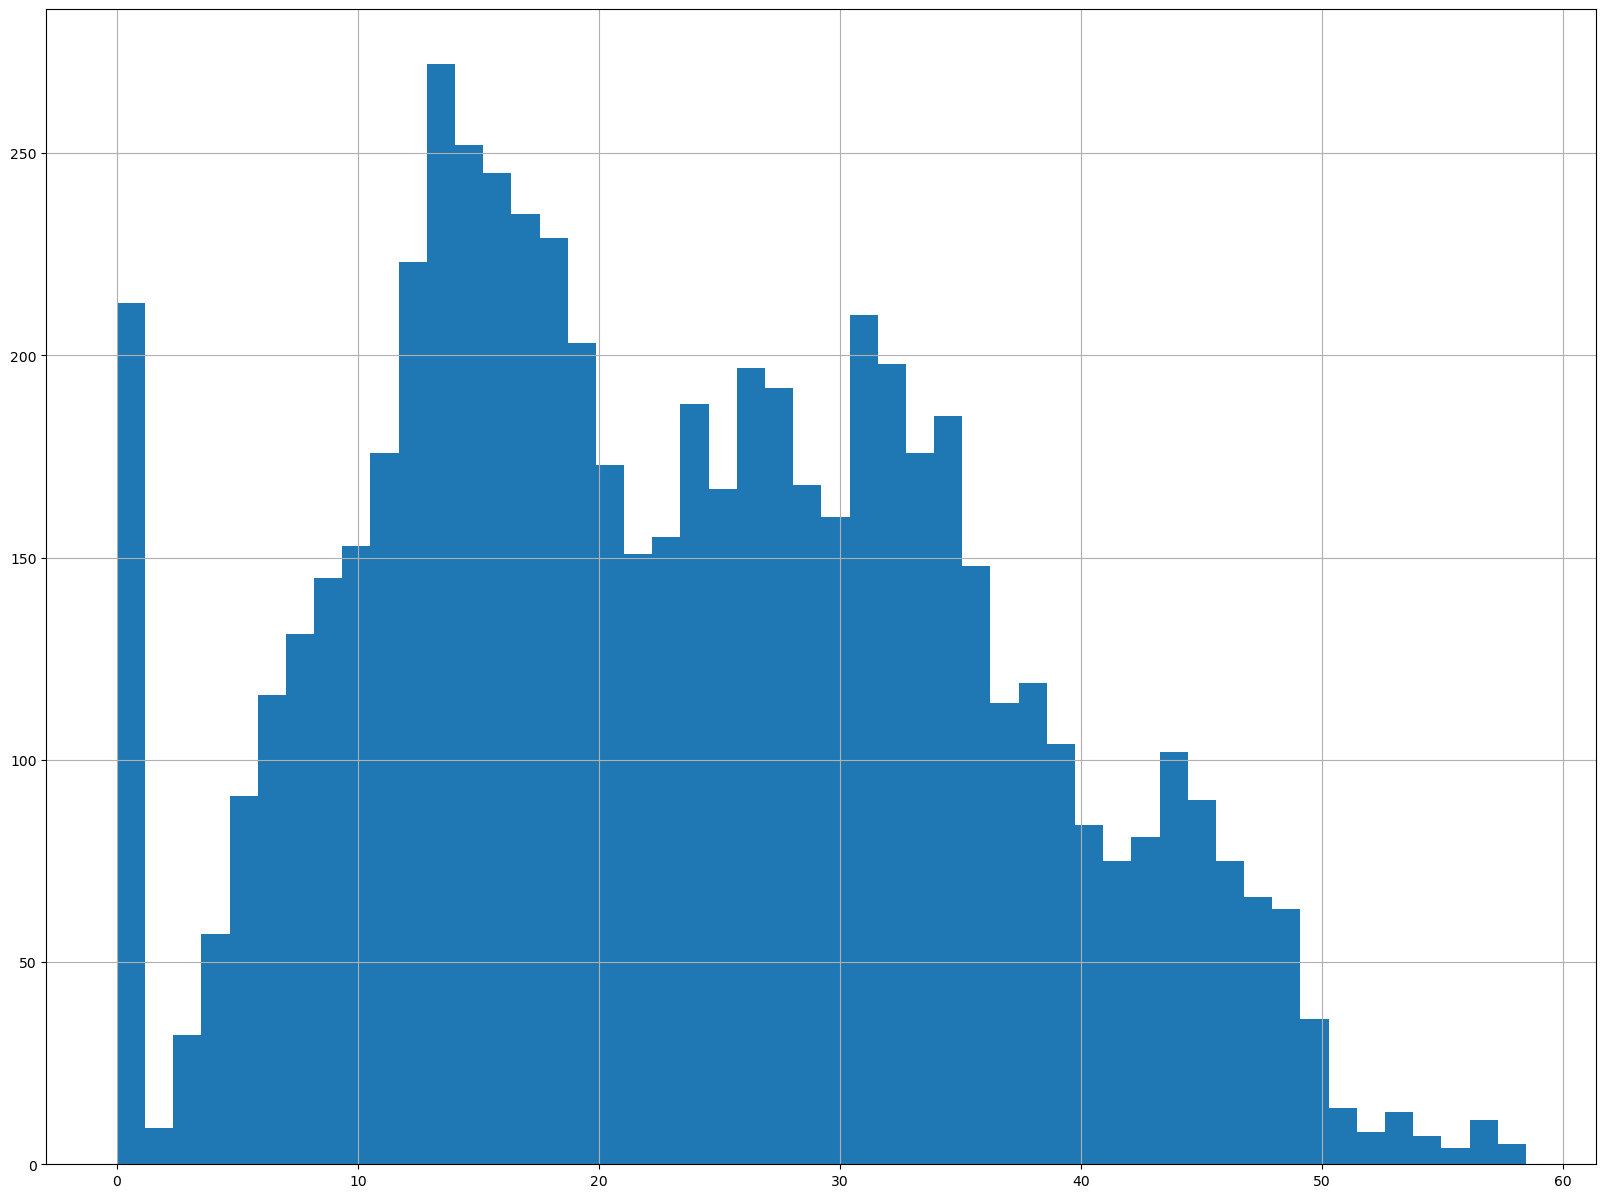

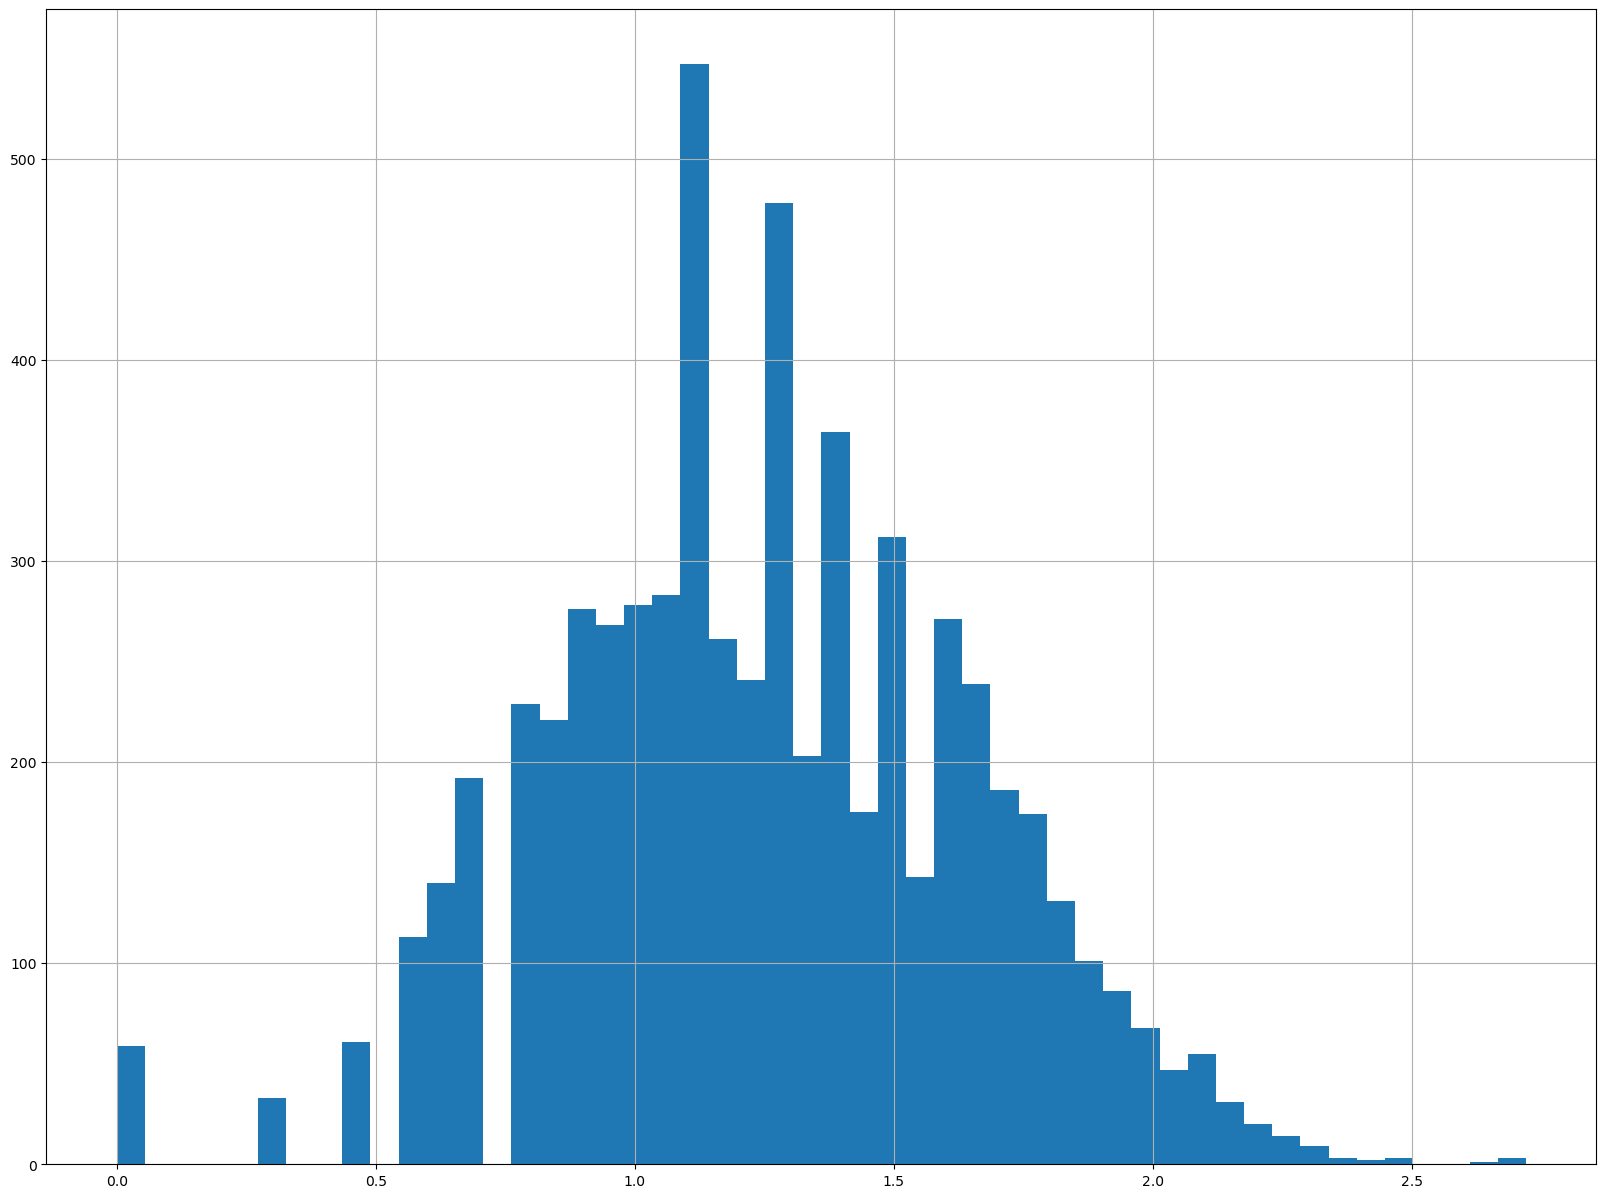

In [16]:
#Provide your answer here
import numpy as np
import math
#from pylab import *
print(np.mean(bs_train_set['Rented Bike Count']))
print(np.median(bs_train_set['Rented Bike Count']))

rbc = []
ws = []
for i in list(bs_train_set['Rented Bike Count']):
    rbc.append(math.pow(i,0.5)) 

for i in list(bs_train_set['Wind speed (m/s)']):
    ws.append(math.pow(i,0.5)) 
    
bs_train_set1 = bs_train_set.copy()
bs_train_set1['Rented Bike Count'] = pd.Series(rbc)
bs_train_set1['Wind speed (m/s)'] = pd.Series(ws)


bs_train_set1['Rented Bike Count'].hist(bins=50,figsize=(20,15))
plt.show()
bs_train_set1['Wind speed (m/s)'].hist(bins=50,figsize=(20,15))
plt.show()


#### Scatter plots

The Scatter plot is a tool we can use to explore dependencies between the different variables. It contains plots of each variable against each other in the dataset. If there are many variables in the feature vector, including all scatter plots might not be convenient to visualise. Let us look at the scatter plot for the target variable and four of the attributes.

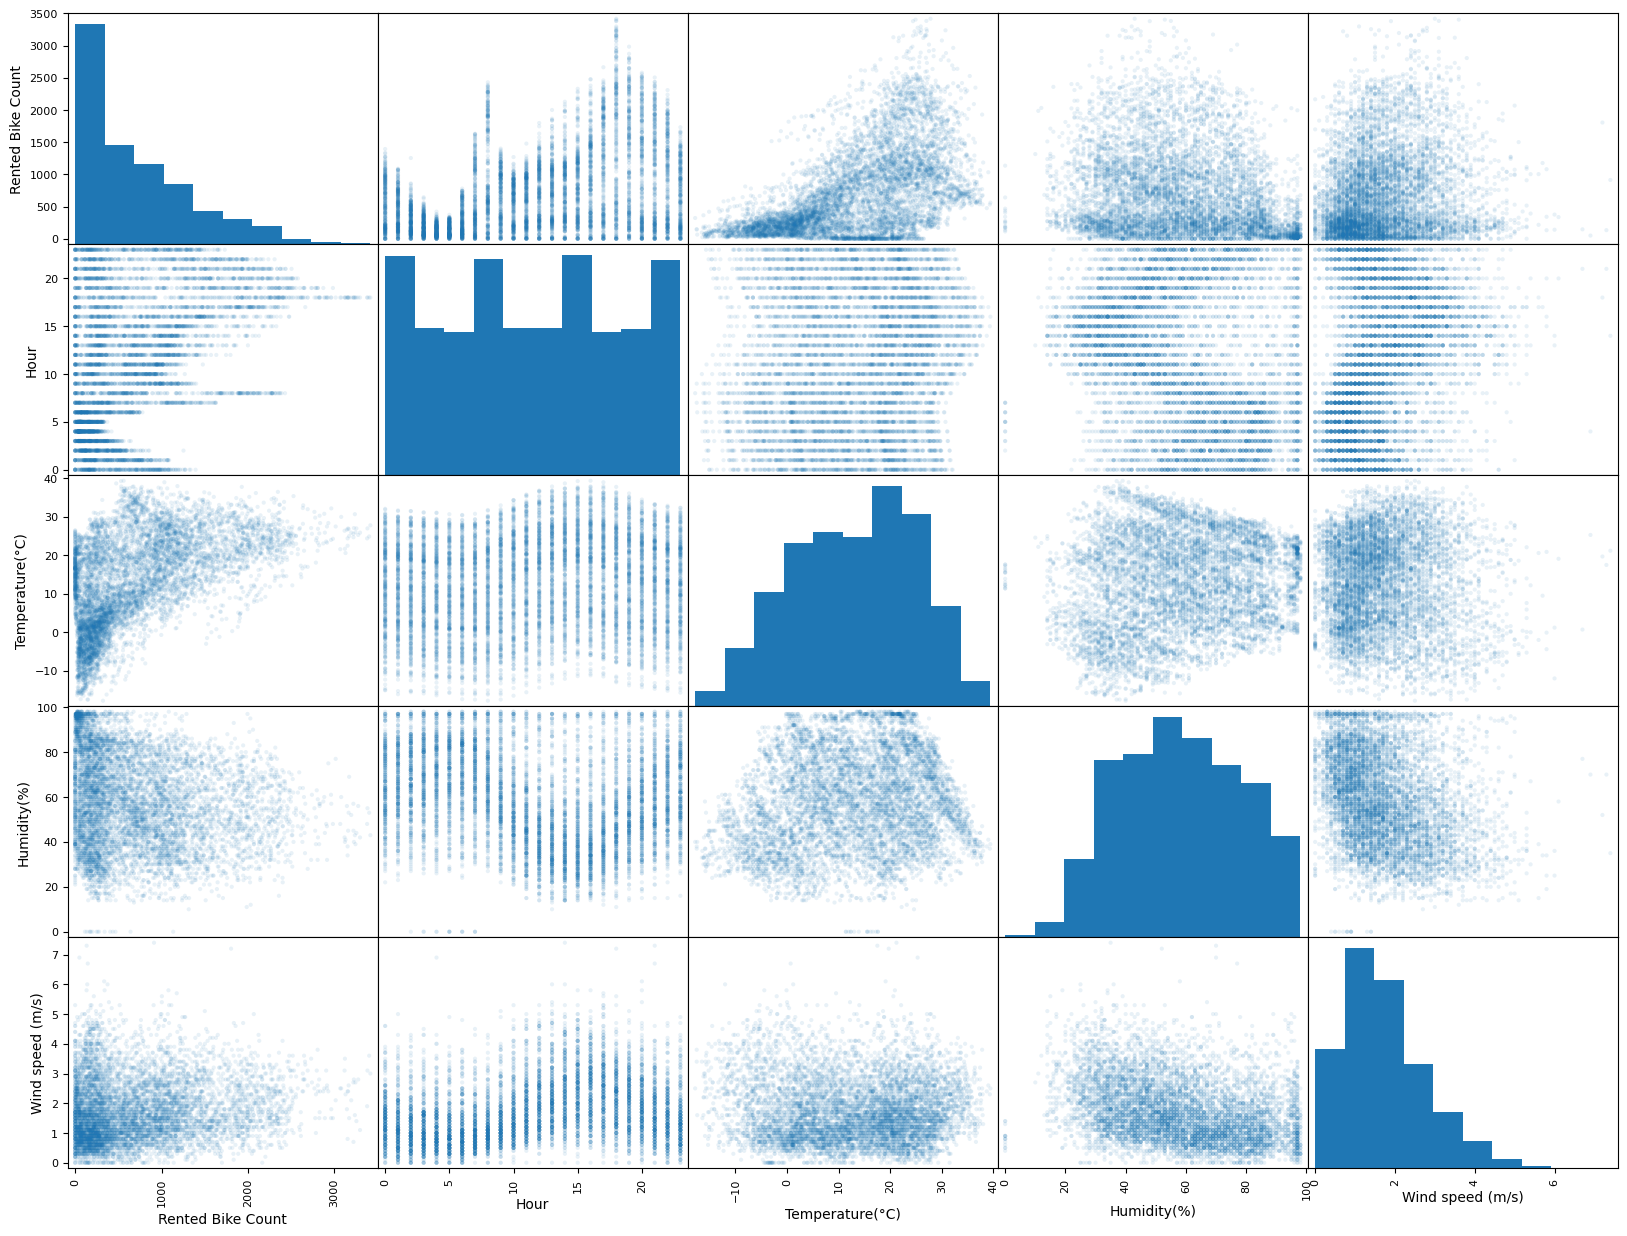

In [17]:
from pandas.plotting import scatter_matrix
attributes = ['Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)']
figscat = scatter_matrix(bs_train_set[attributes], figsize=(20, 15),alpha=0.1)

The variables Hour and Temperature seem correlated with Rented Bike Count. The relationship between Humidity and Wind Speed with Rented Bike Count looks less clear though.

### Correlation coefficients

Additionally, we can study the correlation coefficient between the numerical attributes and the Rented Bike Count.

In [18]:
corr_matrix = bs_train_set.corr()
corr_matrix['Rented Bike Count'].sort_values(ascending=False)

C:\Users\adhir\AppData\Local\Temp\ipykernel_9568\1201165686.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = bs_train_set.corr()


Rented Bike Count            1.000000
Temperature(°C)              0.537556
Hour                         0.417382
Dew point temperature(°C)    0.379268
Solar Radiation (MJ/m2)      0.256920
Visibility (10m)             0.203152
Wind speed (m/s)             0.116280
Rainfall(mm)                -0.124748
Snowfall (cm)               -0.142316
Humidity(%)                 -0.198830
Name: Rented Bike Count, dtype: float64

As we suspected by having looked at the scatter plots, Temperature and Hour are strongly correlated with the target value.

#### Question 3

What would be the correlation coefficients if the variables Rented Bike Count and Wind Speed are transformed using $\sqrt{x}$?

In [19]:
# Provide your answer here
corr_matrix = bs_train_set1.corr()
corr_matrix['Rented Bike Count'].sort_values(ascending=False)


C:\Users\adhir\AppData\Local\Temp\ipykernel_9568\3544702718.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = bs_train_set1.corr()


Rented Bike Count            1.000000
Wind speed (m/s)             0.131245
Snowfall (cm)                0.018316
Rainfall(mm)                 0.012060
Solar Radiation (MJ/m2)      0.003311
Hour                        -0.000619
Humidity(%)                 -0.006202
Temperature(°C)             -0.006544
Visibility (10m)            -0.007384
Dew point temperature(°C)   -0.009985
Name: Rented Bike Count, dtype: float64

### Prepare the data

We will now prepare the data so that it is suitable for the machine learning models. We consider the following processes for the dataset in this notebook: using one-hot-encoding for the categorical attributes and feature scaling for the numerical attributes. scikit-learn provides utilities for these tasks:

1. [OneHotEncoder()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?highlight=onehotencoder#sklearn.preprocessing.OneHotEncoder) allows to transform a categorical variable to a one-hot encoding representation.

2. [StandardScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn.preprocessing.StandardScaler) performs feature scaling by standardisation.

`OneHotEncoder()` and `StandardScaler()` are part of the scikit-learn [preprocessing module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing).

#### Question 4

Explore the scikit-learn [preprocessing module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing). List and explain two of the utilities availaible that you believe are useful for data analysis.

*(answer depends on which utilities people choose)*

`OneHotEncoder()` and `StandardScaler()` are examples of [data transformations](https://scikit-learn.org/stable/data_transforms.html). In scikit-learn these are referred to as *transformers* and they map the data from one format to another. In a programming context, transformers are classes. They come with the following methods:

- `fit` that is used to learn the  transformation from data.
- `transform` that is used to transform the data once the transformer has been fitted.   
- `fit_transform` that applies first `fit` and then `transform` to the data.

Typically, we use either `fit` or `fit_transform` for the training data and `transform` for the validation or test data.

Since the one-hot-encoding and standardisation transformations are often used, rather than code such function from scratch we make use of the [ColumnTransformer()](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html?highlight=columntransformer#sklearn.compose.ColumnTransformer), an estimator available in scikit-learn that allows to group different transformations into a single method. `ColumnTransformer` is an example of an *estimator* in scikit-learn. An estimator is an object that provides predictions for new data.

#### Question 5

A [pipeline](https://scikit-learn.org/stable/modules/compose.html#pipeline) is a convenient estimator in scikit-learn. Explain what a pipeline is, and describe in which situations it is useful.

*Provide your answer here*

To apply the transformation we need a list of the categorical attributes and a list of the numerical attributes:

In [20]:
attributes_cat = ['Seasons', 'Holiday', 'Functioning Day']
attributes_num = ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', \
                  'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

We now import `OneHotEncoder`, `StandardScaler` and `ColumnTransformer` and create the actual transformer

In [21]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

full_transform = ColumnTransformer([
    ("num", StandardScaler(), attributes_num),
    ("cat", OneHotEncoder(), attributes_cat),
])

Before applying the full transformation, we separate the target feature from the attributes

In [22]:
bs_train_set_attributes = bs_train_set.drop('Rented Bike Count', axis=1)
bs_train_set_labels = bs_train_set['Rented Bike Count']

We can now apply the fit and apply the full transformation to the training data using `fit_transform`

In [23]:
bs_train_set_attributes_prepared = full_transform.fit_transform(bs_train_set_attributes)

### Short-list models and fine-tune them

Scikit-learn includes [many different predictive models for regression and classification](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). In this notebook, we will focus on Linear Regression as a simple example.

We import the [LinearRegression()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html?highlight=linearregression#sklearn.linear_model.LinearRegression) method and fit it to the training data.

In [24]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(bs_train_set_attributes_prepared, bs_train_set_labels)

LinearRegression()

And that's it! We have fit the ML model. What's next? Well, by now, one may feel tempted to apply the model to the test data to see how it performs. However, one should only do this when being absolutely sure that this is the best performing model on a *validation set*.

We have not used a validation set up until this point because we have not needed to compare between two alternative models. To see how to fine-tune the model, *let us use a validation set to decide whether including the features Rainfall and Snowfall has any benefits*

#### Fine-tuning the model

We take the original training set and split it again into a train set and a validation set. As we have a reasonably large dataset, we use *holdout validation*, in which we hold out a single set of data for validation. If the dataset were smaller we might consider using k-fold cross-validation. Both are implemented in scikit-learn ([k-fold cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) and [leave-one-out cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html?highlight=leave%20one%20out#sklearn.model_selection.LeaveOneOut).)

From the original training set, we use 85% for the train set and 15% for the validation set.

In [25]:
bs_train2_set, bs_val_set = train_test_split(bs_train_set, test_size=0.15, random_state=42)

##note: if we just want to split the data into training being the first 85% and test being the last 15%
##this code would allow us to do that...
#bs_train_set = bs_train_set.sort_index()
#bs_train2_set, bs_val_set = bs_train_set[:6329], bs_train_set[6329:]

bs_train2_set_attributes = bs_train2_set.drop('Rented Bike Count', axis=1)
bs_train2_set_labels = bs_train2_set['Rented Bike Count']
bs_val_set_attributes = bs_val_set.drop('Rented Bike Count', axis=1)
bs_val_set_labels = bs_val_set['Rented Bike Count']

We will be comparing between two transformations, the one we already described with `full_transform` and one that looks similar except from not including Rainfall and Snowfall.

In [26]:
attributes_num_partial = ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', \
                  'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)']
partial_transform = ColumnTransformer([
    ("num", StandardScaler(), attributes_num_partial),
    ("cat", OneHotEncoder(), attributes_cat),
])

We now use this new transformation to fit_transform the new train set

In [27]:
bs_train2_set_no_RS_attributes = partial_transform.fit_transform(bs_train2_set_attributes)

We now train the linear regression model that only uses the partial transformed attributes

In [28]:
lin_reg_mod = LinearRegression()
lin_reg_mod.fit(bs_train2_set_no_RS_attributes, bs_train2_set_labels)

LinearRegression()

Let us now assess the performance of this model over the validation data. We first need to prepare the validation input data.

In [29]:
bs_val_set_no_RS_attributes = partial_transform.transform(bs_val_set_attributes)

We now compute the predictions made by the linear model

In [30]:
bs_val_set_predictions_mod = lin_reg_mod.predict(bs_val_set_no_RS_attributes)

We can now compute the RMSE obtained with this predictive model. We can use the [scikit-learn routine for computing the mean squared error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) and then compute the square root.

In [31]:
from sklearn.metrics import mean_squared_error
import numpy as np
error_mod = np.sqrt(mean_squared_error(bs_val_set_labels, bs_val_set_predictions_mod))
error_mod

414.64885759078004

Let us now look into using all the numerical attributes. The train set has changed, so we need to fit_transform a new full transformer.

In [32]:
bs_train2_set_all_attributes = full_transform.fit_transform(bs_train2_set_attributes)

We creat the new linear regression model

In [33]:
lin_reg = LinearRegression()
lin_reg.fit(bs_train2_set_all_attributes, bs_train2_set_labels)

LinearRegression()

Transform the validation data

In [34]:
bs_val_set_all_attributes = full_transform.transform(bs_val_set_attributes)

We finally perform the prediction

In [35]:
bs_val_set_predictions = lin_reg.predict(bs_val_set_all_attributes)
error = np.sqrt(mean_squared_error(bs_val_set_labels, bs_val_set_predictions))
error

412.7141451928566

We conclude from this that the variables Rainfall and Snowfall actually help to slightly improve the predictions. But is this a useful or significant improvement?

### Question 6

Perhaps other transformations to the dataset can help to improve the predictions. Try the following transformations and see whether the RMSE over the validation set reduces even more:

1. Before standardising the feature Wind speed, first transform it using $\sqrt{x}$.
2. Transform the Rainfall and the Snowfall to discrete features using the scikit-learn utility [KBinsDiscretizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer) with $K=5$.
3. Instead of doing standardisation over the other numerical features, use normalisation.
4. Keep the one-hot-encoding for the categorical features.

In [54]:
# (answers here)
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import Normalizer

attributes_cat1 = ['Seasons', 'Holiday', 'Functioning Day']
attributes_num1 = ['Hour', 'Temperature(°C)', 'Humidity(%)', \
                  'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)']

partial_transform1 = ColumnTransformer([
    ("num", Normalizer(), attributes_num1),
    ("cat", OneHotEncoder(), attributes_cat1),
])


bs_train_set1_attributes = bs_train_set1.drop('Wind speed (m/s)', axis=1)
bs_train_set1_labels = bs_train_set1['Wind speed (m/s)']

bs_train_set1_attributes_prepared = partial_transform1.fit_transform(bs_train_set1_attributes)





Between chosing to include Rainfall and Snowfall or not, the stage of validation tells us we should include them. If this was the only hyperparameter to choose from, we would be done and we could proceed to compute the generalisation error on the test set. Since we are not considering more fine-tuning at the moment, let us compute the RMSE over the test set. We have already prepared the whole training data (what we called train2+val) before using the full transform, we called it `bs_train_set_attributes_prepared`

In [55]:
lin_reg1 = LinearRegression()
lin_reg1.fit(bs_train_set1_attributes_prepared, bs_train_set1_labels)

ValueError: Input y contains NaN.

Let us transform the test data so that we can apply the fitted model correctly

In [ ]:
bs_test_set_attributes = bs_test_set.drop('Rented Bike Count', axis=1)
bs_test_set_labels = bs_test_set['Rented Bike Count']

We now transform the attributes in the test set

In [ ]:
bs_test_set_attributes_prepared = full_transform.transform(bs_test_set_attributes)

We perform the prediction

In [ ]:
bs_test_set_predictions = lin_reg.predict(bs_test_set_attributes_prepared)

And compute the RMSE

In [ ]:
error_test = np.sqrt(mean_squared_error(bs_test_set_labels, bs_test_set_predictions))
error_test

The performance in the test set is slightly worse when compared to the performance in the validation set.